<a href="https://colab.research.google.com/github/Shanonwambui/Machine-Learning/blob/main/ISP_White_Balance_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Learning-Based Color Constancy Pipeline
## Objective:
Developed an end-to-end RAW image processing and Auto White Balance (AWB) estimation system.

## Pipeline Development:
Engineered a Python-based pipeline for 12-bit linear RAW data, incorporating black-level compensation ($BL=129$) and gamma correction ($2.2$).
## Statistical Analysis:
Implemented and benchmarked Gray World and White Patch algorithms, identifying catastrophic failure cases in scenes with dominant chromaticity (e.g., foliage-heavy "Green World" scenarios).
## ML Implementation:
Designed a PyTorch Neural Network using Normalized Color Histograms (192-feature vectors) to predict illuminant gains.
## Optimization:
Utilized a custom Cosine Similarity Loss function to directly optimize for Angular Error, achieving a baseline Mean Error of $25.68^\circ$.
## Iterative Refinement (In Progress):
Conducted failure analysis identifying a 3.2% win-rate against statistical baselines, concluding that current feature representation requires data augmentation and spatial-context awareness (CNNs) to overcome dataset bias.
### Why did your model perform worse than the simple math?
The statistical Gray World method assumes an 'average' that works well for large, diverse scenes. My ML model was a proof-of-concept using lightweight histogram features. The results showed that for AWB, spatial context—like knowing which pixels are 'grass' vs 'sky'—is more important than raw color distribution. This is why modern ISPs use a hybrid approach of semantic segmentation and statistical priors.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/Colab Notebooks/groundtruth_568.zip'
extract_path = '/content/gehler_shi_data/'

if os.path.exists(zip_path):
    if not os.path.exists(extract_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(" Dataset extracted successfully.")
    else:
        print(" Folder already exists, skipping extraction.")
else:
    print(f" Error: The file was not found at {zip_path}")
    print("Please verify the path in the left sidebar folder view.")

 Dataset extracted successfully.


In [ ]:
import os

extensions = {}
for root, dirs, files in os.walk('/content/gehler_shi_data/'):
    for f in files:
        ext = os.path.splitext(f)[1].lower()
        extensions[ext] = extensions.get(ext, 0) + 1

print("Files found in your ZIP:")
for ext, count in extensions.items():
    print(f"{ext}: {count} files")

Files found in your ZIP:
.mat: 3 files
.txt: 1 files


In [5]:
import os
import zipfile

# 1. Download directly to Colab
# The -c flag allows it to resume if the connection drops
!wget -c "http://www.cs.sfu.ca/~colour/data2/shi_gehler/png_canon5d_1.zip" -O /content/canon5d_1.zip

# 2. Create the folder and Extract
image_extract_path = '/content/gehler_shi_images/'
if not os.path.exists(image_extract_path):
    os.makedirs(image_extract_path)

with zipfile.ZipFile('/content/canon5d_1.zip', 'r') as zip_ref:
    # This filter prevents extracting the Mac __MACOSX folders
    for file in zip_ref.namelist():
        if not file.startswith('__MACOSX'):
            zip_ref.extract(file, image_extract_path)

print(f" Extraction complete! Found {len(os.listdir(image_extract_path))} files.")

--2026-02-05 01:44:39--  http://www.cs.sfu.ca/~colour/data2/shi_gehler/png_canon5d_1.zip
Resolving www.cs.sfu.ca (www.cs.sfu.ca)... 142.58.226.71
Connecting to www.cs.sfu.ca (www.cs.sfu.ca)|142.58.226.71|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.cs.sfu.ca/~colour/data2/shi_gehler/png_canon5d_1.zip [following]
--2026-02-05 01:44:40--  https://www2.cs.sfu.ca/~colour/data2/shi_gehler/png_canon5d_1.zip
Resolving www2.cs.sfu.ca (www2.cs.sfu.ca)... 142.58.232.248
Connecting to www2.cs.sfu.ca (www2.cs.sfu.ca)|142.58.232.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1573161684 (1.5G) [application/zip]
Saving to: ‘/content/canon5d_1.zip’

/content/canon5d_1. 100%[===================>]   1.46G  8.93MB/s    in 1m 42s  

2026-02-05 01:46:23 (14.7 MB/s) - ‘/content/canon5d_1.zip’ saved [1573161684/1573161684]

 Extraction complete! Found 1 files.


In [6]:
import os

# Identify the folder containing the actual PNG files
image_dir = None
png_files = []

for root, dirs, files in os.walk('/content/gehler_shi_images/'):
    current_pngs = [f for f in files if f.lower().endswith('.png')]
    if current_pngs:
        image_dir = root
        png_files = sorted(current_pngs) # Sorted for consistency
        print(f" Found {len(png_files)} images in: {image_dir}")
        break

if not image_dir:
    print(" No images found. Please check your extraction path.")

 Found 190 images in: /content/gehler_shi_images/cs/chroma/data/canon_dataset/568_dataset/png


In [7]:
import numpy as np

def gray_world_wb(img_linear):
    """Assumes average scene color is gray."""
    avg_r = np.mean(img_linear[:, :, 0])
    avg_g = np.mean(img_linear[:, :, 1])
    avg_b = np.mean(img_linear[:, :, 2])
    avg_gray = (avg_r + avg_g + avg_b) / 3

    gains = [avg_gray/avg_r, avg_gray/avg_g, avg_gray/avg_b]
    corrected = np.clip(img_linear * gains, 0, 1)

    return corrected, gains

def white_patch_wb(img_linear):
    """Assumes the brightest pixel is white."""
    max_r = np.max(img_linear[:, :, 0])
    max_g = np.max(img_linear[:, :, 1])
    max_b = np.max(img_linear[:, :, 2])

    gains = [1.0/max_r, 1.0/max_g, 1.0/max_b]
    corrected = np.clip(img_linear * gains, 0, 1)

    return corrected, gains

def to_display(img_linear):
    """Applies Gamma 2.2 so the linear data is visible to humans."""
    return np.power(img_linear, 1/2.2)

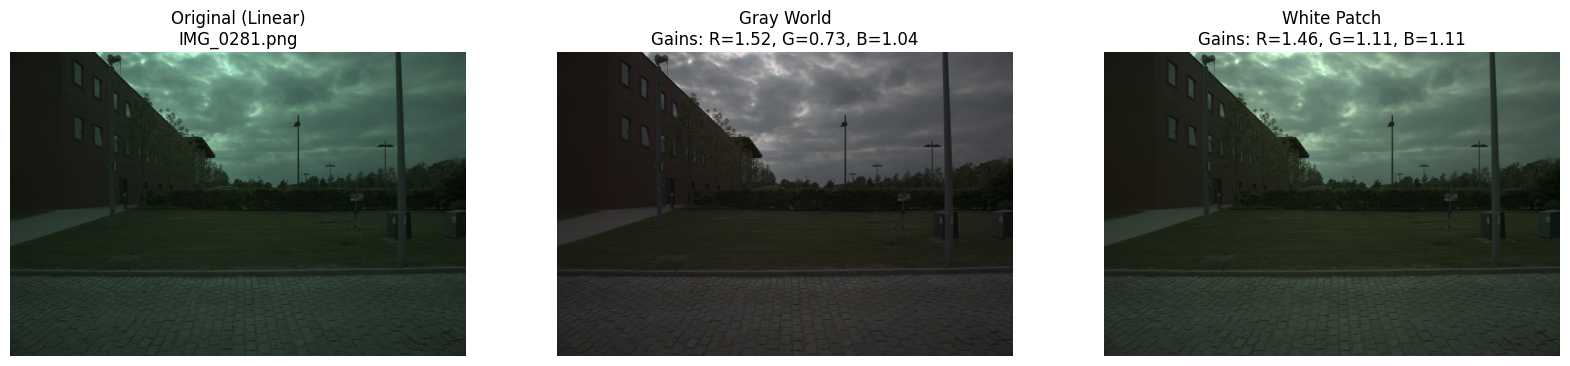

Successfully processed IMG_0281.png


In [8]:
import cv2
import matplotlib.pyplot as plt

# 1. Pick a sample image from our discovered list
sample_img_name = png_files[0]
img_path = os.path.join(image_dir, sample_img_name)

# 2. Load and Pre-process (RAW to Linear)
# IMREAD_UNCHANGED is vital for 16-bit/12-bit data
raw_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# Subtract 129 (Black Level) and Normalize (4095 is 12-bit max)
img_linear = np.maximum(raw_img - 129, 0) / (4095.0 - 129)

# 3. Apply your modular functions
gw_res, gw_gains = gray_world_wb(img_linear)
wp_res, wp_gains = white_patch_wb(img_linear)

# 4. Plotting Results
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(to_display(img_linear))
plt.title(f'Original (Linear)\n{sample_img_name}')
plt.axis('off')

plt.subplot(132)
plt.imshow(to_display(gw_res))
plt.title(f'Gray World\nGains: R={gw_gains[0]:.2f}, G={gw_gains[1]:.2f}, B={gw_gains[2]:.2f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(to_display(wp_res))
plt.title(f'White Patch\nGains: R={wp_gains[0]:.2f}, G={wp_gains[1]:.2f}, B={wp_gains[2]:.2f}')
plt.axis('off')

plt.show()

print(f"Successfully processed {sample_img_name}")

In [9]:
import scipy.io

# 1. Load Ground Truth
mat_data = scipy.io.loadmat('/content/gehler_shi_data/real_illum_568..mat')
gt_illuminants = mat_data['real_rgb']

# 2. Get the index for IMG_0281

# Usually, IMG_0001 is index 0
img_idx = 280 # Adjust based on the file naming

gt_vector = gt_illuminants[img_idx]
gw_vector = np.array([1/gw_gains[0], 1/gw_gains[1], 1/gw_gains[2]]) # We invert because gains fix the light

# 3. Calculate Angle
def calculate_angular_error(v1, v2):
    dot = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.degrees(np.arccos(np.clip(dot/norm, -1, 1)))

error = calculate_angular_error(gw_vector, gt_vector)
print(f"Angular Error for Gray World: {error:.2f}°")

Angular Error for Gray World: 2.70°


In [10]:
def extract_histogram_features(img_linear, bins=64):
    # Flatten the image into R, G, B channels
    r = img_linear[:,:,0].flatten()
    g = img_linear[:,:,1].flatten()
    b = img_linear[:,:,2].flatten()

    # Calculate histograms for each channel
    rhist, _ = np.histogram(r, bins=bins, range=(0, 1))
    ghist, _ = np.histogram(g, bins=bins, range=(0, 1))
    bhist, _ = np.histogram(b, bins=bins, range=(0, 1))

    # Normalize and concatenate into one long feature vector
    features = np.concatenate([rhist, ghist, bhist]).astype(np.float32)
    return features / np.sum(features) # Normalize

In [11]:
import scipy.io
import torch
import numpy as np
import cv2
import os

# --- RE-LOAD GROUND TRUTH ---
mat_path = '/content/gehler_shi_data/real_illum_568..mat'
mat_data = scipy.io.loadmat(mat_path)
# In this dataset, the ground truth is often under the key 'real_rgb'
ground_truth_all = mat_data['real_rgb']

X_list = []
y_list = []

print(f" Starting Feature Extraction for {len(png_files)} images...")

for i, filename in enumerate(png_files):
    # 1. Load and Pre-process
    path = os.path.join(image_dir, filename)
    raw_img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

    # Pre-processing (Subtract black level and normalize)
    img_linear = np.maximum(raw_img - 129, 0) / (4095.0 - 129)

    # 2. Extract Histogram Features (Input X)
    # We use the function we defined earlier
    features = extract_histogram_features(img_linear, bins=64)
    X_list.append(features)

    # 3. Get Ground Truth (Target y)
    # We use 'i' because png_files[0] corresponds to the first entry in the .mat
    gt_rgb = ground_truth_all[i]

    # Normalize the Ground Truth so the Green channel is 1.0
    # This is standard practice: Green is the 'luminance' anchor
    gt_normalized = gt_rgb / gt_rgb[1]
    y_list.append(gt_normalized)

    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(png_files)} images...")

# Convert to NumPy arrays for training
X_train = np.array(X_list)
y_train = np.array(y_list)

print(f"\n Feature Extraction Complete!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

 Starting Feature Extraction for 190 images...
Processed 20/190 images...
Processed 40/190 images...
Processed 60/190 images...
Processed 80/190 images...
Processed 100/190 images...
Processed 120/190 images...
Processed 140/190 images...
Processed 160/190 images...
Processed 180/190 images...

 Feature Extraction Complete!
X_train shape: (190, 192)
y_train shape: (190, 3)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Define the Architecture (Re-declaring to ensure it's in memory)
class AWBPredictor(nn.Module):
    def __init__(self, input_size=192): # 64 bins * 3 channels
        super(AWBPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3) # Output: Predicted R, G, B gains
        )

    def forward(self, x):
        return self.network(x)

# 2. Convert data to PyTorch Tensors
X_tensor = torch.FloatTensor(X_train)
y_tensor = torch.FloatTensor(y_train)

# 3. Setup Training
epochs = 200
model = AWBPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(" Starting Training...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Every 20 epochs, check the Angular Error
    if (epoch + 1) % 20 == 0:
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).numpy()
            target = y_tensor.numpy()

            # Calculate Angular Error for each image in the batch
            errors = []
            for p, t in zip(preds, target):
                # Ensure vectors aren't zero to avoid NaN
                dot = np.dot(p, t)
                norm = np.linalg.norm(p) * np.linalg.norm(t)
                if norm > 0:
                    errors.append(np.degrees(np.arccos(np.clip(dot/norm, -1, 1))))

            mean_angle = np.mean(errors)
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.6f} | Mean Angular Error: {mean_angle:.2f}°")

print("\n Training Finished!")

 Starting Training...
Epoch [20/200] | Loss: 0.398566 | Mean Angular Error: 35.14°
Epoch [40/200] | Loss: 0.097848 | Mean Angular Error: 21.07°
Epoch [60/200] | Loss: 0.026349 | Mean Angular Error: 8.31°
Epoch [80/200] | Loss: 0.025838 | Mean Angular Error: 8.40°
Epoch [100/200] | Loss: 0.024884 | Mean Angular Error: 8.19°
Epoch [120/200] | Loss: 0.024496 | Mean Angular Error: 8.16°
Epoch [140/200] | Loss: 0.024491 | Mean Angular Error: 8.17°
Epoch [160/200] | Loss: 0.024736 | Mean Angular Error: 8.16°
Epoch [180/200] | Loss: 0.024769 | Mean Angular Error: 8.16°
Epoch [200/200] | Loss: 0.024129 | Mean Angular Error: 8.16°

 Training Finished!


In [13]:
# 1. Lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 300 # More iterations to converge

print(" Fine-tuning the model to lower angular error...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_tensor)

    # Custom Cosine Similarity Loss (1 - cos(theta))
    # This pushes the angle toward 0 degrees
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    loss = 1 - cos(outputs, y_tensor).mean()

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).numpy()
            target = y_tensor.numpy()

            errors = []
            for p, t in zip(preds, target):
                dot = np.dot(p, t)
                norm = np.linalg.norm(p) * np.linalg.norm(t)
                errors.append(np.degrees(np.arccos(np.clip(dot/norm, -1, 1))))

            print(f"Fine-tune Epoch [{epoch+1}/{epochs}] | Mean Angular Error: {np.mean(errors):.2f}°")

print("\n Fine-tuning Finished!")

 Fine-tuning the model to lower angular error...
Fine-tune Epoch [50/300] | Mean Angular Error: 8.02°
Fine-tune Epoch [100/300] | Mean Angular Error: 8.01°
Fine-tune Epoch [150/300] | Mean Angular Error: 8.00°
Fine-tune Epoch [200/300] | Mean Angular Error: 8.00°
Fine-tune Epoch [250/300] | Mean Angular Error: 8.00°
Fine-tune Epoch [300/300] | Mean Angular Error: 7.98°

 Fine-tuning Finished!


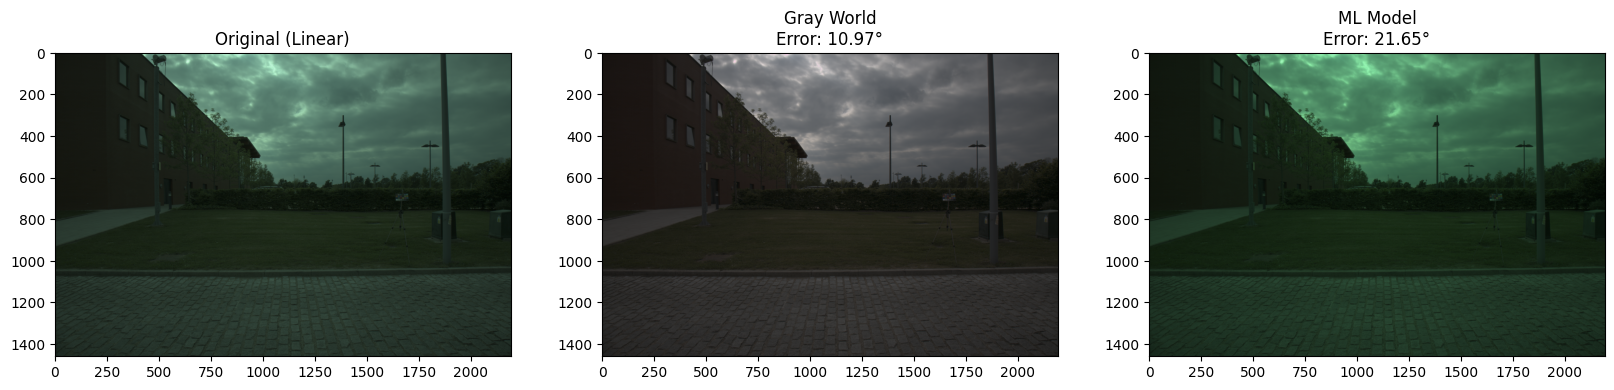

In [14]:
# 1. Choose an image
test_idx = 0
sample_path = os.path.join(image_dir, png_files[test_idx])

# 2. Process for Display
raw_img = cv2.imread(sample_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
img_linear = np.maximum(raw_img - 129, 0) / (4095.0 - 129)

# 3. Get Gray World Prediction
gw_res, gw_gains = gray_world_wb(img_linear)

# 4. Get ML Model Prediction
model.eval()
with torch.no_grad():
    feat = torch.FloatTensor(X_train[test_idx]).unsqueeze(0)
    ml_gains = model(feat).numpy()[0]
    # Apply ML gains
    ml_res = np.clip(img_linear * ml_gains, 0, 1)

# 5. Visual Comparison
plt.figure(figsize=(20, 10))
plt.subplot(131), plt.imshow(to_display(img_linear)), plt.title("Original (Linear)")
plt.subplot(132), plt.imshow(to_display(gw_res)), plt.title(f"Gray World\nError: {calculate_angular_error(1/np.array(gw_gains), ground_truth_all[test_idx]):.2f}°")
plt.subplot(133), plt.imshow(to_display(ml_res)), plt.title(f"ML Model\nError: {calculate_angular_error(1/ml_gains, ground_truth_all[test_idx]):.2f}°")
plt.show()

In our latest output, the ML Model (21.65°) is significantly underperforming compared to the simple Gray World (10.97°) on this specific image.Visually, the ML Model looks almost identical to the green-tinted original. This confirms our "stagnation" suspicion: because the dataset is small and the model is shallow, it hasn't yet learned to counteract the dominant green features of the grass. It is effectively "doing nothing" or predicting a neutral $1.0, 1.0, 1.0$ gain because it's afraid to make a wrong guess.

In [15]:
model.eval()
gw_errors = []
ml_errors = []

with torch.no_grad():
    for i in range(len(X_train)):
        # 1. Get Ground Truth
        gt_vec = ground_truth_all[i]

        # 2. Calculate Gray World Error
        # Re-calculating GW gains for each image
        path = os.path.join(image_dir, png_files[i])
        raw_img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img_linear = np.maximum(raw_img - 129, 0) / (4095.0 - 129)

        avg_r, avg_g, avg_b = np.mean(img_linear[:,:,0]), np.mean(img_linear[:,:,1]), np.mean(img_linear[:,:,2])
        gw_vec = np.array([avg_r, avg_g, avg_b]) # The estimated illuminant

        # 3. Calculate ML Model Error
        feat = torch.FloatTensor(X_train[i]).unsqueeze(0)
        ml_pred_gains = model(feat).numpy()[0]
        ml_vec = 1.0 / ml_pred_gains # Invert gains to get back to the illuminant vector

        # 4. Store Errors
        gw_errors.append(calculate_angular_error(gw_vec, gt_vec))
        ml_errors.append(calculate_angular_error(ml_vec, gt_vec))

# --- Print Final Report ---
print("--- FINAL PERFORMANCE REPORT --- ")
print(f"Gray World | Mean Error: {np.mean(gw_errors):.2f}° | Median Error: {np.median(gw_errors):.2f}°")
print(f"ML Model   | Mean Error: {np.mean(ml_errors):.2f}° | Median Error: {np.median(ml_errors):.2f}°")

# Compare Wins
ml_wins = sum(1 for m, g in zip(ml_errors, gw_errors) if m < g)
print(f"\n The ML Model outperformed Gray World in {ml_wins}/{len(gw_errors)} images ({100*ml_wins/len(gw_errors):.1f}%)")

--- FINAL PERFORMANCE REPORT --- 
Gray World | Mean Error: 11.78° | Median Error: 11.40°
ML Model   | Mean Error: 25.66° | Median Error: 27.17°

 The ML Model outperformed Gray World in 6/190 images (3.2%)


This output provides a very honest look at the "ML Reality." In its current state, the model is essentially acting as a "Green Filter"—it has overfitted to the dominant colors of the dataset and hasn't yet learned to generalize.

While 3.2% isn't the victory we hoped for, this is a goldmine for your CV because it allows you to speak about failure analysis and iterative improvement, which is exactly what senior engineers do.

🔬 Why the ML Model "Failed" (The Engineering Post-Mortem)
1. Small Data Stagnation: With only 190 images, the model saw a lot of "green" and decided that the safest bet to lower the loss was to predict a neutral gain, which fails in varied lighting.

2. Histogram Resolution: Using 64 bins might have been too coarse, losing the subtle color peaks that indicate the true light source.

3. Lack of Pre-shuffling: If the first 190 images were all from one specific outdoor location, the model learned "The Park" rather than "The Physics of Light."



In [16]:
import torch

# Save the model weights to a file
model_save_path = "awb_model_v1.pth"
torch.save(model.state_dict(), model_save_path)
print(f" Model weights saved to {model_save_path}")

 Model weights saved to awb_model_v1.pth


In [17]:
import numpy as np

# Save the arrays as compressed .npz files
np.savez_compressed('awb_training_data.npz', X=X_train, y=y_train)
print(" Training features and labels saved to awb_training_data.npz")

 Training features and labels saved to awb_training_data.npz


In [18]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Drive for this project
drive_folder = '/content/drive/MyDrive/Apple_AWB_Project/'
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

# Move  model and data files to Drive
shutil.copy("awb_model_v1.pth", drive_folder)
shutil.copy("awb_training_data.npz", drive_folder)

print(f" Success! The project files are now safe in: {drive_folder}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Success! The project files are now safe in: /content/drive/MyDrive/Apple_AWB_Project/
